In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor

from scipy import stats

In [2]:
df = pd.read_csv("Clean_Dataset.csv",index_col=0)
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


In [4]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


<AxesSubplot:xlabel='price', ylabel='Count'>

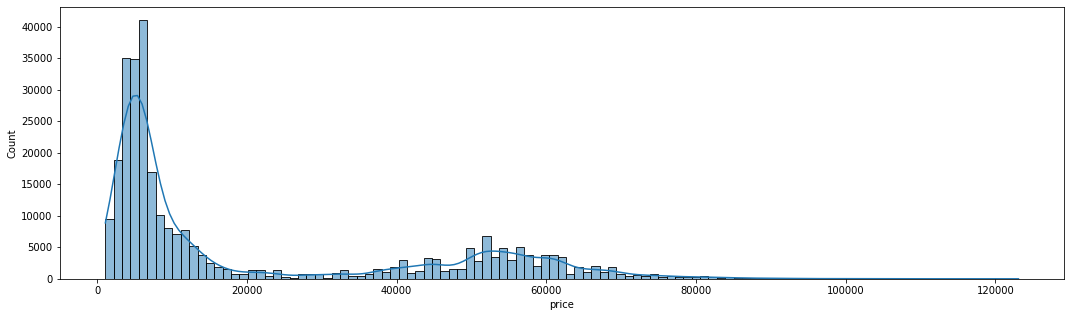

In [5]:
plt.figure(figsize = (18,5))
sns.histplot(x = 'price', data = df, kde = True)

<AxesSubplot:xlabel='price'>

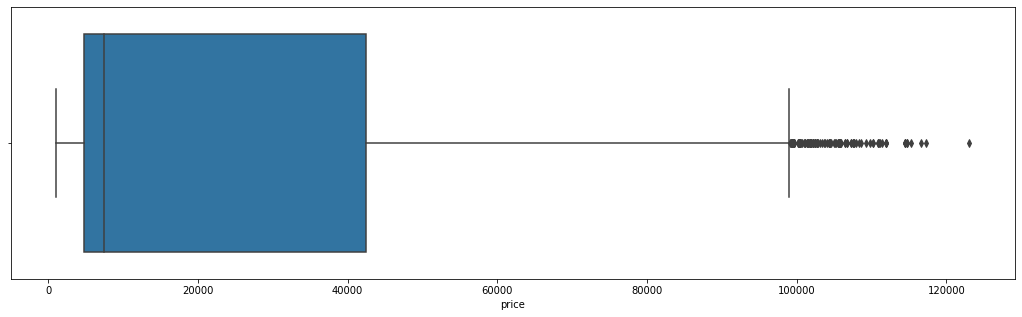

In [6]:
plt.figure(figsize = (18,5))
sns.boxplot(x = 'price', data = df)

<AxesSubplot:xlabel='price', ylabel='Count'>

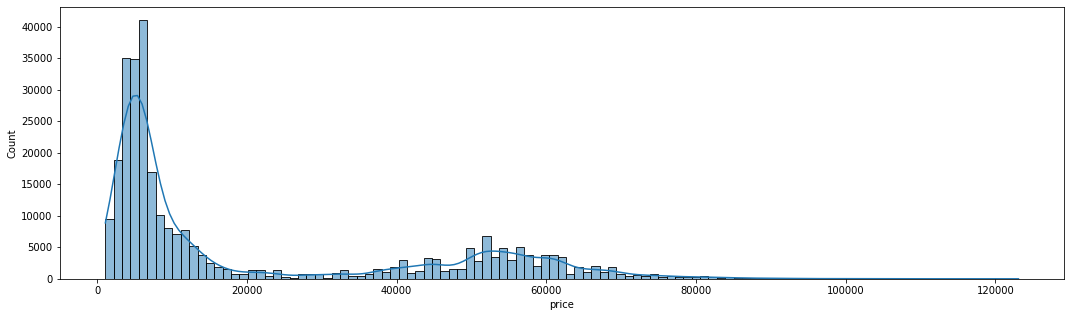

In [7]:
plt.figure(figsize = (18,5))
sns.histplot(x = 'price', data = df, kde = True) # Has two peaks

In [8]:
df['price'].mean()

20889.660523133203

In [9]:
df['price'].median()

7425.0

In [10]:
# Even  though mean is 20889, the median is only 7425 
# This can be due to presence of both economic and business class

Text(0.5, 1.0, 'Airline prices based on the class and company')

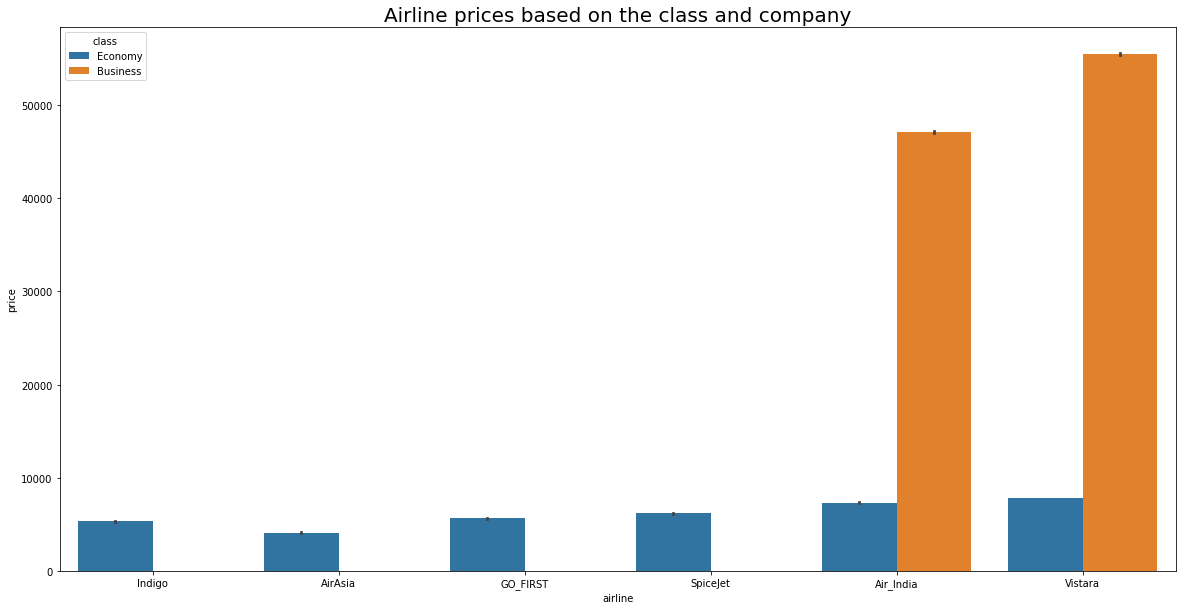

In [11]:
# Now lets explore ticket price of economy and business class
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=df.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

<AxesSubplot:xlabel='airline', ylabel='price'>

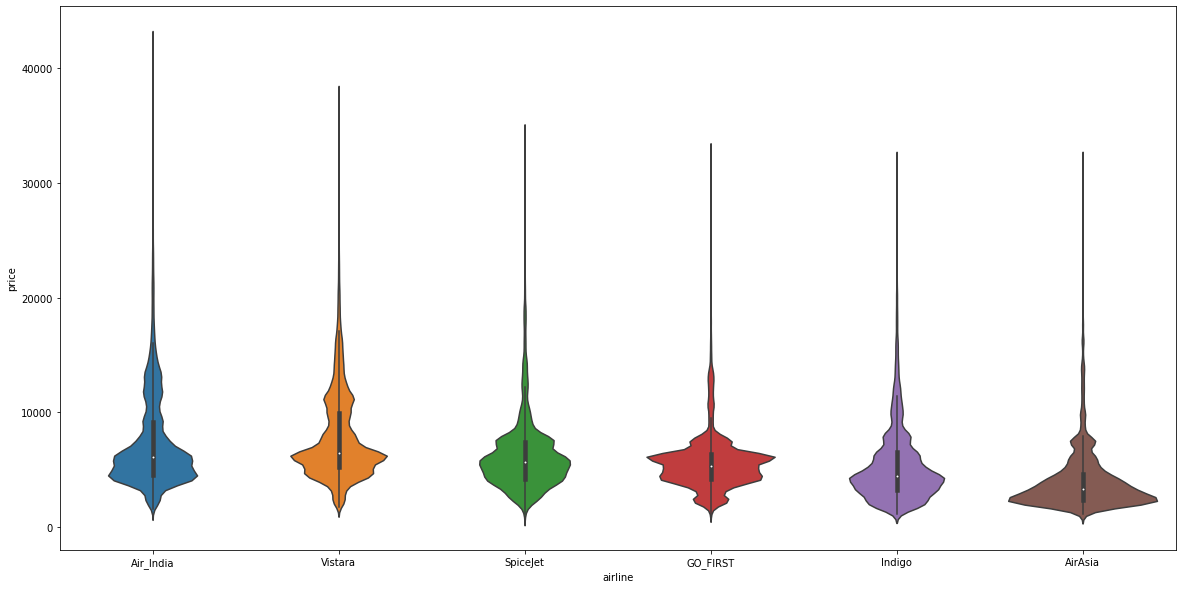

In [12]:
## Now we will see price variation with respective class and airlines

plt.figure(figsize=(20, 10))
sns.violinplot(y='price',x='airline',data=df.loc[df['class']=='Economy'].sort_values('price',ascending=False),kind='boxen')

<AxesSubplot:xlabel='airline', ylabel='price'>

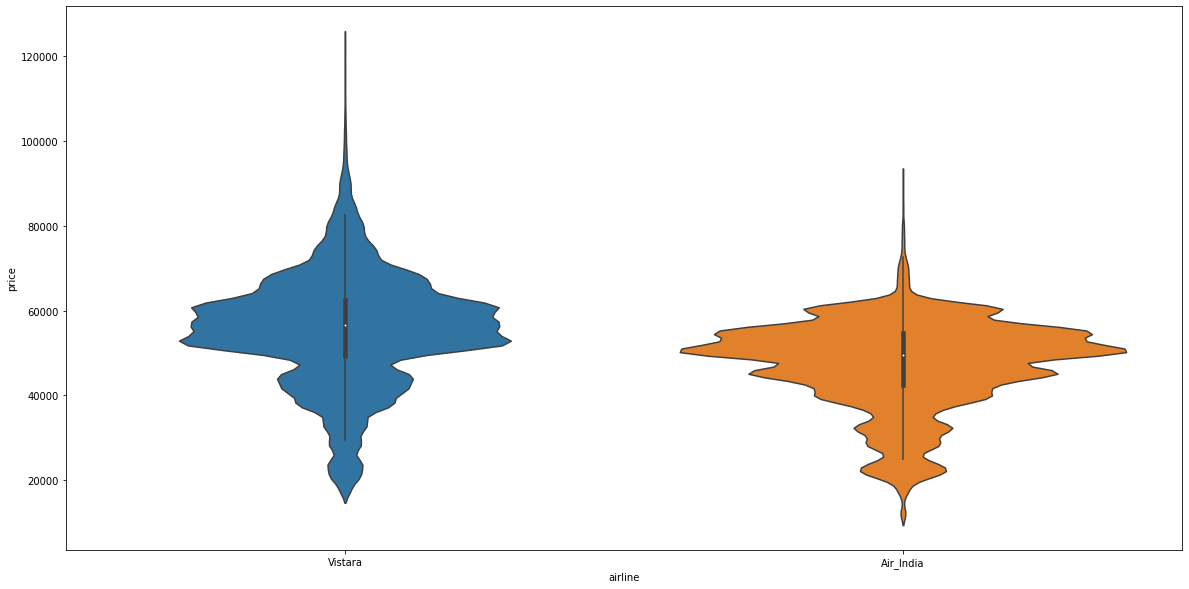

In [13]:
## Now we will see price variation with respective class and airlines

plt.figure(figsize=(20, 10))
sns.violinplot(y='price',x='airline',data=df.loc[df['class']=='Business'].sort_values('price',ascending=False),kind='boxen')

<Figure size 1440x720 with 0 Axes>

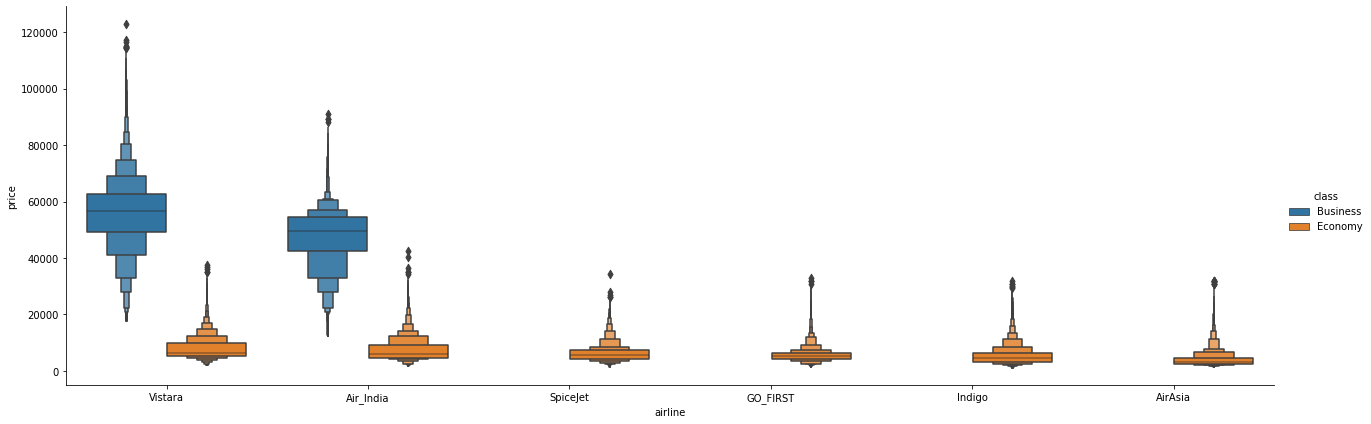

In [14]:
plt.figure(figsize=(20, 10))
sns.catplot(y = "price", x = "airline",hue='class',data = df.sort_values("price", ascending = False),kind='boxen',height=6,aspect=3)

<Figure size 3600x2160 with 0 Axes>

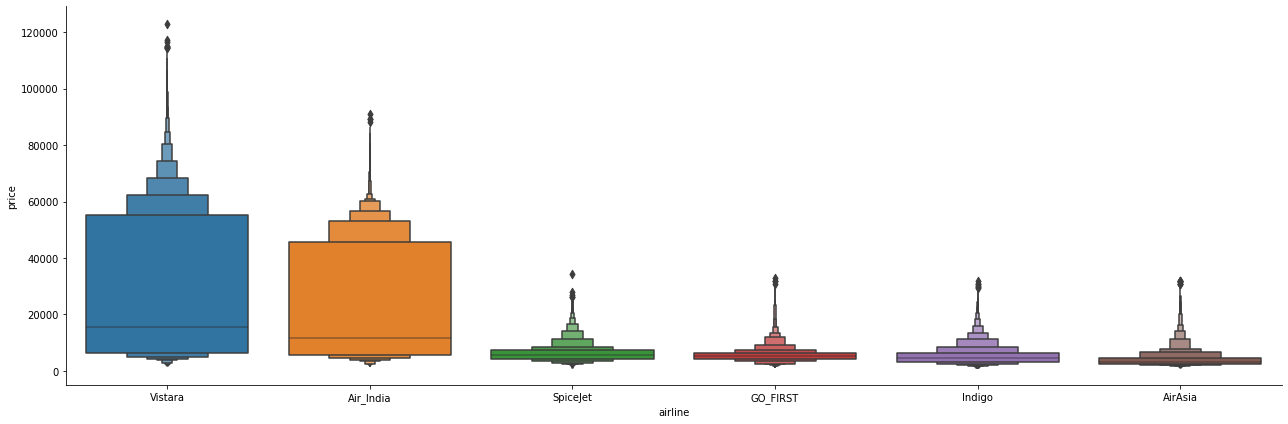

In [15]:
plt.figure(figsize=(50, 30))
sns.catplot(y = "price", x = "airline",data = df.sort_values("price", ascending = False),kind='boxen',height=6,aspect=3)

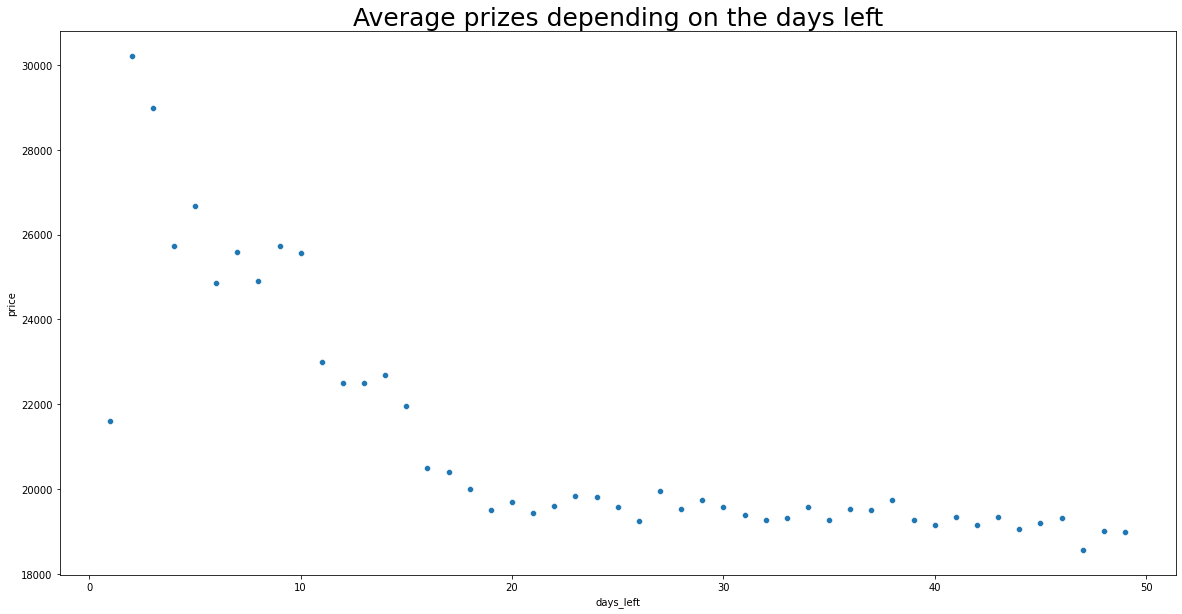

In [16]:
### How are price affected based on the days left
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=25)

<AxesSubplot:xlabel='days_left', ylabel='price'>

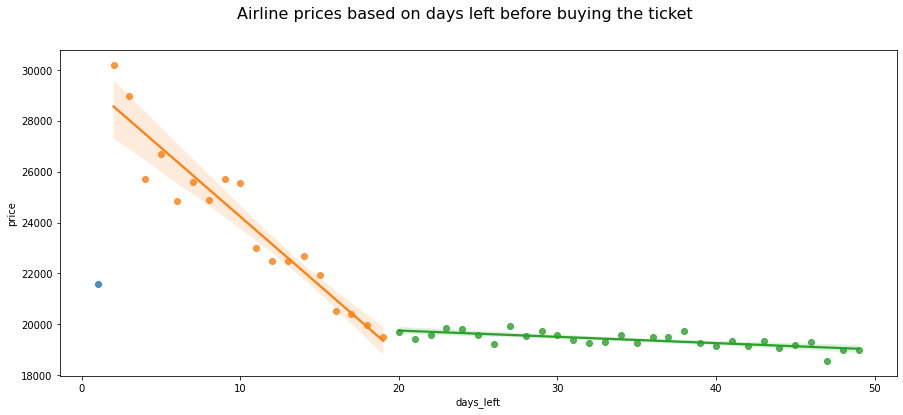

In [17]:
plt.figure(figsize=(15,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=16)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)

<AxesSubplot:xlabel='stops', ylabel='price'>

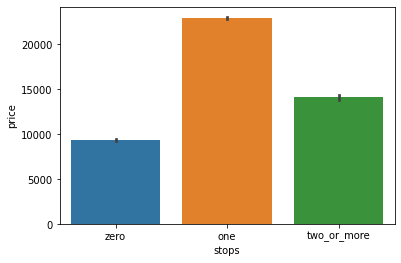

In [18]:
### How prices affected based on stops
sns.barplot(x='stops',y='price',data=df)

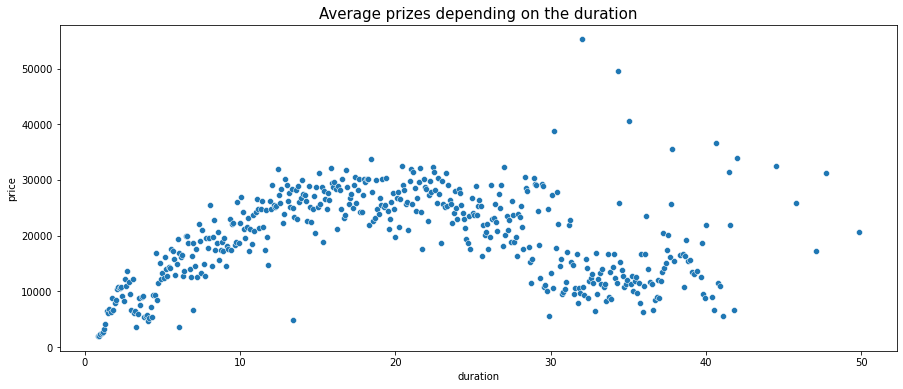

In [19]:
# How the price change with duration of the flight
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

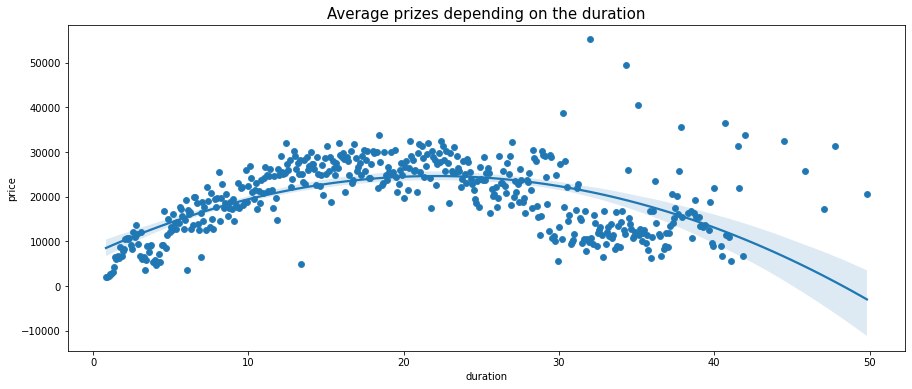

In [20]:
plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)
ax = sns.regplot(x="duration", y="price", data=df_temp, order=2)

In [21]:
# we observe above is not linear and has outliers

Text(0.5, 1.0, 'Airline prices based on the departure time')

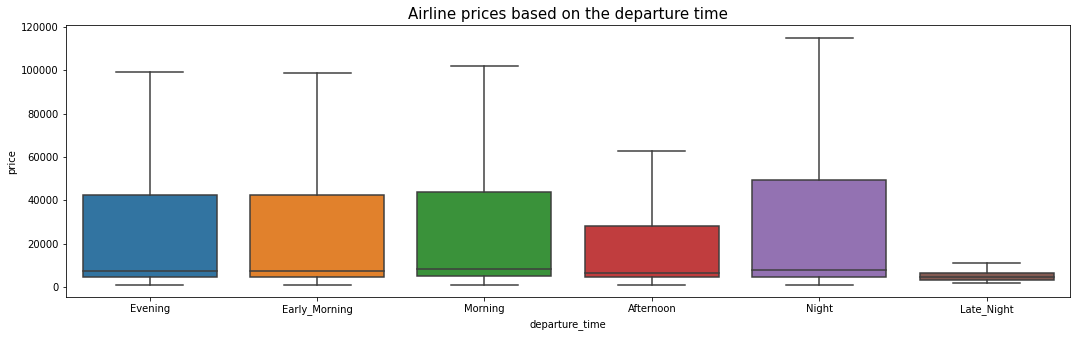

In [22]:
# Relation of ticket price based on departure time and arrival time
plt.figure(figsize = (18,5))
sns.boxplot(data=df, y="price", x="departure_time",showfliers=False).set_title("Airline prices based on the departure time",fontsize=15)

Text(0.5, 1.0, 'Airline prices based on the arrival time')

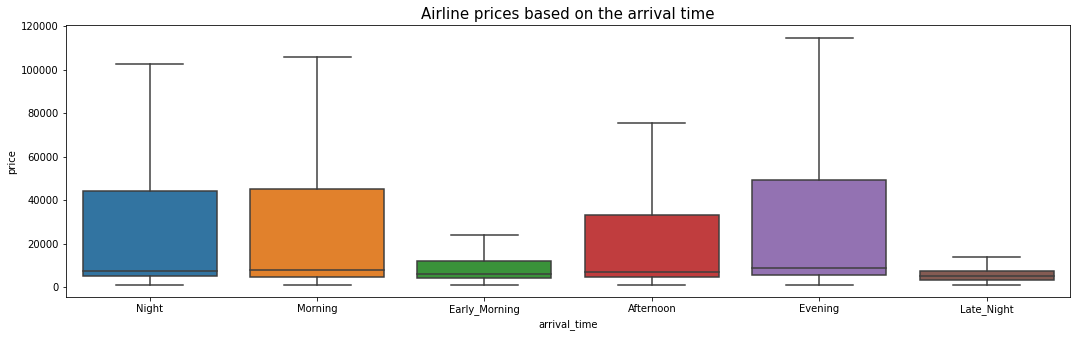

In [23]:
plt.figure(figsize = (18,5))
sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False).set_title("Airline prices based on the arrival time",fontsize=15)

Text(0.5, 0.98, 'Airline prices based on the source and destination cities')

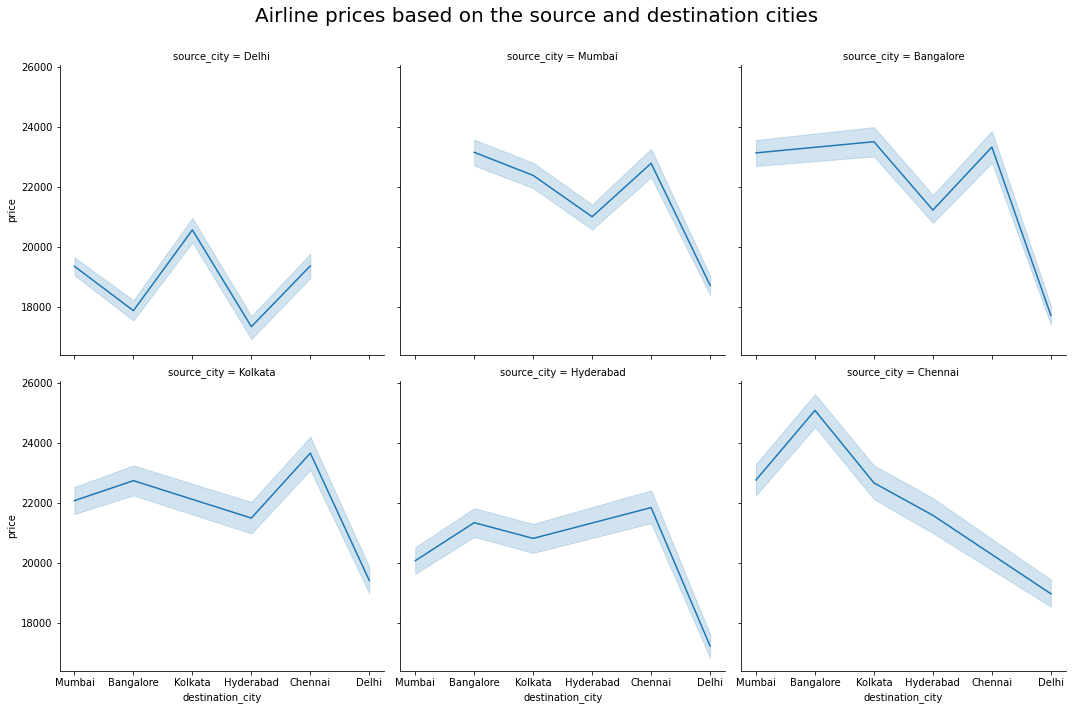

In [24]:
## Price depending on different source-destination
ax = sns.relplot(col="source_city", y="price", kind="line",x='destination_city', data=df, col_wrap=3)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Airline prices based on the source and destination cities',fontsize=20)

<AxesSubplot:xlabel='airline', ylabel='price'>

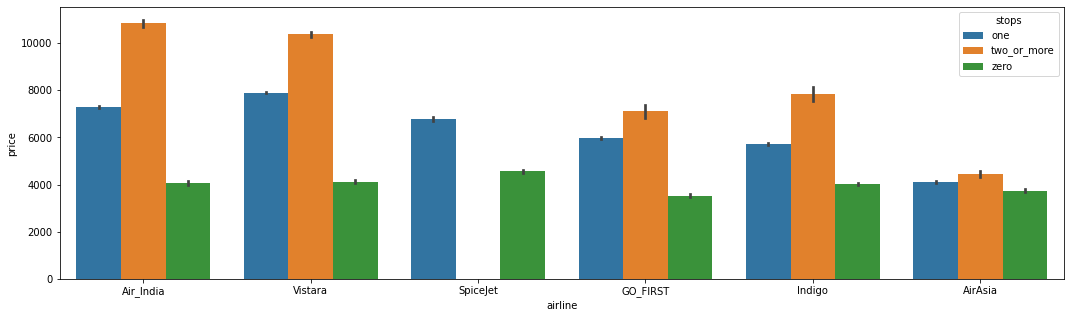

In [25]:
## The effect of number of stops on price
plt.figure(figsize = (18,5))
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False))

<AxesSubplot:xlabel='airline', ylabel='price'>

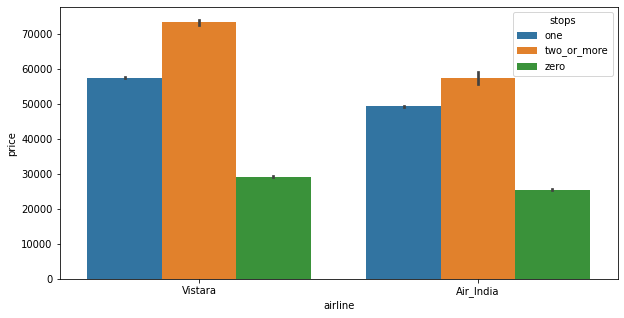

In [26]:
plt.figure(figsize = (10,5))
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False))

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [20]:
df1 = df.copy()

In [21]:
for ele in df1.select_dtypes('object').columns:
    df1[ele]=encoder.fit_transform(df1[ele])
df1.drop('flight',axis=1,inplace=True)

In [22]:
df1.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,2,5,5,1,2.17,1,5953
1,4,2,1,2,4,5,1,2.33,1,5953
2,0,2,1,2,1,5,1,2.17,1,5956
3,5,2,4,2,0,5,1,2.25,1,5955
4,5,2,4,2,4,5,1,2.33,1,5955


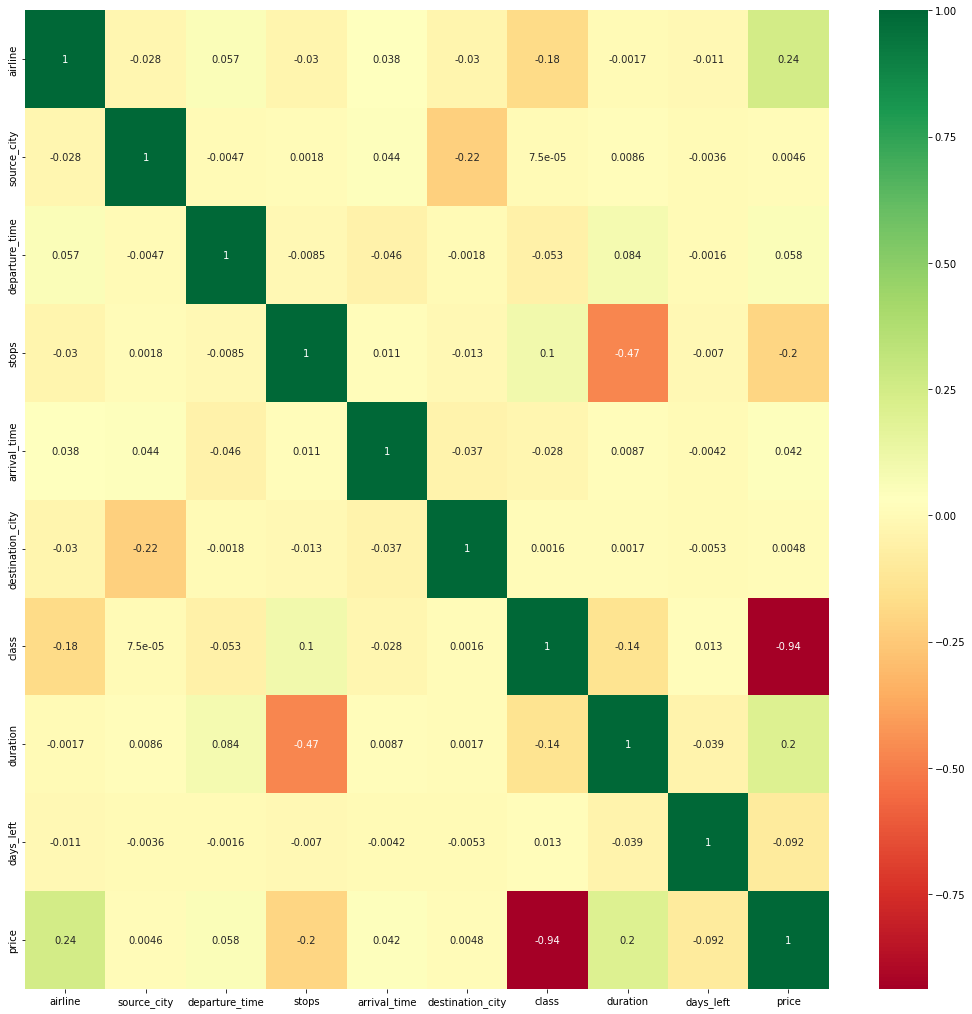

In [23]:
plt.figure(figsize = (18,18))
sns.heatmap(df1.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [32]:
Y=df1['price']
X=df1.drop('price',axis=1)

In [91]:
X

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,4,2,2,2,5,5,1,2.17,1
1,4,2,1,2,4,5,1,2.33,1
2,0,2,1,2,1,5,1,2.17,1
3,5,2,4,2,0,5,1,2.25,1
4,5,2,4,2,4,5,1,2.33,1
...,...,...,...,...,...,...,...,...,...
300148,5,1,4,0,2,3,0,10.08,49
300149,5,1,0,0,5,3,0,10.42,49
300150,5,1,1,0,5,3,0,13.83,49
300151,5,1,1,0,2,3,0,10.00,49


In [ ]:
output=round(prediction[0],2)

In [117]:
for ele in df1.columns:
    print(df1[ele].unique())

[4 0 5 2 3 1]
[2 5 0 4 3 1]
[2 1 4 0 5 3]
[2 0 1]
[5 4 1 0 2 3]
[5 0 4 3 1 2]
[1 0]
[ 2.17  2.33  2.25  2.08 12.25 16.33 11.75 14.5  15.67  3.75  2.5   5.83
  8.    6.   14.67 16.17 18.   23.17 24.17  8.83  4.5  15.25 11.   19.08
 22.83 26.42 17.75 19.58 26.67 15.17 20.83 11.42 22.25 26.   21.75  3.83
  4.42  7.67  8.33 10.42 23.75 19.5   6.5  12.42 21.08 28.17 28.25  9.25
 17.92  7.08 13.83  7.58 15.83 24.42  4.17  4.25  5.08 29.33 17.   27.17
 24.75  5.75 12.75 13.75 17.83  5.5  23.83  5.   26.5  12.83  8.92 11.17
 12.17 15.58 15.75  7.92 13.25 16.   22.75  6.33  7.25 30.08 18.25  6.08
  2.   12.33  3.5  10.25 14.17 25.58  4.08  9.75  6.67  9.67 10.08 12.58
  7.    8.25 15.5  10.17 23.5  25.75 11.5  21.42 14.25  7.75  5.33  5.67
  4.75 19.33  6.25 10.33  9.08 15.42  4.83 25.83  7.5  27.58 28.42  6.42
 24.58 16.5  11.33 24.83 14.92 26.08  5.42 28.5  27.33  8.67 20.42 20.08
  5.92 20.58 26.17 17.5  18.33 21.83 26.83 13.42 19.25 23.58 23.92 12.08
 14.42 25.92 18.58 13.08  4.58 21.58 10.

In [90]:
Y

0          5953
1          5953
2          5956
3          5955
4          5955
          ...  
300148    69265
300149    77105
300150    79099
300151    81585
300152    81585
Name: price, Length: 300153, dtype: int64

In [96]:
### Train test split
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=42)

In [70]:
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=42)}
models["RandomForestRegressor"]={"model":RandomForestRegressor(n_estimators=50,max_depth=10)}
models['GradientBoostingRegressor'] = {'model':GradientBoostingRegressor(n_estimators=50,max_depth=10)}

In [71]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()
    
    return score_r2

In [72]:
 def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
        score = {'model':"Linear regression", 'score_r2':score_r2}
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("\n")

In [45]:
get_scores(models,x_train,y_train)

--- KNeighborsRegressor ---
Score r2: 0.45818849011641494


--- LinearRegression ---
Score r2: 0.9046079694062019


--- XGBRegressor ---
Score r2: 0.9826349622601509


--- RandomForestRegressor ---
Score r2: 0.9634738765628794


--- GradientBoostingRegressor ---
Score r2: 0.9766507252038006




In [73]:
# Linear Regression

step1 = LinearRegression()

pipe = Pipeline([
    ('step1',step1)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print("R2 Score",r2_score(y_test,y_pred))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred))

R2 Score 0.9046540517018563
Mean Absolute Error 4626.099183664053


In [74]:
# Ridge Regression


step2 = Ridge(alpha=15)

pipe = Pipeline([
    ('step2',step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print("R2 Score",r2_score(y_test,y_pred))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred))

R2 Score 0.9046546492219623
Mean Absolute Error 4626.8109260601


In [75]:
# Lasso Regression

step2 = Lasso(alpha=0.00048)

pipe = Pipeline([
    ('step2',step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print("R2 Score",r2_score(y_test,y_pred))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred))

R2 Score 0.9046540519461733
Mean Absolute Error 4626.0990369834235


In [76]:
# KNN

step2 = KNeighborsRegressor(n_neighbors=3)

pipe = Pipeline([
    ('step2',step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.6931969577872081
MAE 8267.787464184972


In [77]:
# Decision Tree

step2 = DecisionTreeRegressor(max_depth=17)

pipe = Pipeline([
    ('step2',step2)
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)

print("R2 Score",r2_score(y_test,y_pred))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred))

R2 Score 0.9761848674016221
Mean Absolute Error 1584.5887017622622


In [85]:
# Random Forest

step2 = RandomForestRegressor(n_estimators=700,
                              min_samples_split=15,
                              min_samples_leaf= 1,
                              bootstrap= True,
                              max_features='auto',
                              max_depth=20)
pipe1 = Pipeline([
    ('step2',step2)
])

pipe1.fit(x_train,y_train)

y_pred = pipe1.predict(x_test)

print("R2 Score",r2_score(y_test,y_pred))
print("Mean Absolute Error",mean_absolute_error(y_test,y_pred))

C:\Users\Asus Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


R2 Score 0.9851262939087155
Mean Absolute Error 1278.847866790771


In [110]:
import pickle

file = open('random_forest.pkl','wb')
pickle.dump(pipe2,file)

In [86]:
from sklearn.model_selection import RandomizedSearchCV

In [87]:
# Extra Trees Regressor


step2 = ExtraTreesRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=None,
                              max_features=0.75,
                              max_depth=15)

pipe2 = Pipeline([
    ('step2',step2)
])

pipe2.fit(x_train,y_train)

y_pred = pipe2.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.9760149742377283
MAE 1892.0472120267443


In [111]:
import pickle

file = open('extra_trees.pkl','wb')
pickle.dump(pipe5,file)

In [97]:
# Ada Boost


step2 = AdaBoostRegressor(n_estimators=15,learning_rate=1.0)

pipe3 = Pipeline([
    ('step2',step2)
])

pipe3.fit(x_train,y_train)

y_pred = pipe3.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.9333091724496809
MAE 3667.856407789984


In [103]:
# XG Boost


step2 = XGBRegressor(n_estimators=38,max_depth=20,learning_rate=0.5)


pipe4 = Pipeline([
    ('step2',step2)
])

pipe4.fit(x_train,y_train)

y_pred = pipe4.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

R2 score 0.9836943815329351
MAE 1253.6096360427935


In [114]:
import pickle

file = open('xgboost1.pkl','wb')
pickle.dump(pipe4,file)

In [104]:
################
##### Some Multiple models
# Voting Regressor
from sklearn.ensemble import VotingRegressor,StackingRegressor


rf = RandomForestRegressor(n_estimators=700,
                              min_samples_split=15,
                              min_samples_leaf= 1,
                              bootstrap= True,
                              max_features='auto',
                              max_depth=20)
xg = XGBRegressor(n_estimators=38,max_depth=20,learning_rate=0.5)

step2 = VotingRegressor([('rf', rf),('xg',xg)],weights=[5,5])

pipe5 = Pipeline([
    ('step2',step2)
])

pipe5.fit(x_train,y_train)

y_pred = pipe5.predict(x_test)

print('R2 score',r2_score(y_test,y_pred))
print('MAE',mean_absolute_error(y_test,y_pred))

C:\Users\Asus Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


R2 score 0.9861418885345554
MAE 1191.4497114542219


In [106]:
import pickle

file = open('model.pkl','wb')
pickle.dump(pipe5,file)

In [109]:
import pickle
with open('model1.pickle','wb') as f:
    pickle.dump(pipe5,f)
    
import json
columns={
    'data_columns':[col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [119]:
pipe5

Pipeline(steps=[('step2',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(max_depth=20,
                                                                    max_features='auto',
                                                                    min_samples_split=15,
                                                                    n_estimators=700)),
                                             ('xg',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=No...
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.5,
                                                           max_bin=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=20,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=38,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=None,
                                                           reg_alpha=None,
                                                           reg_lambda=None, ...))],
                                 weights=[5, 5]))])

In [122]:
y = pipe5.predict(x_test)

In [123]:
print(y,y_test)

[ 5787.15926613 67064.59461766  6269.86780906 ...  2576.03292091
  2632.62246054  3518.26884561] 27131      7366
266857    64831
141228     6195
288329    60160
97334      6578
          ...  
123895     6134
251253    67004
8335       2410
68668      2835
108970     3393
Name: price, Length: 90046, dtype: int64


In [124]:
y

array([ 5787.15926613, 67064.59461766,  6269.86780906, ...,
        2576.03292091,  2632.62246054,  3518.26884561])

In [125]:
y_test

27131      7366
266857    64831
141228     6195
288329    60160
97334      6578
          ...  
123895     6134
251253    67004
8335       2410
68668      2835
108970     3393
Name: price, Length: 90046, dtype: int64

In [126]:
x_test

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
27131,1,2,4,0,1,4,1,19.75,40
266857,5,4,4,0,5,5,0,9.83,42
141228,5,4,4,0,5,0,1,10.50,41
288329,5,1,5,0,4,2,0,14.50,14
97334,1,0,0,0,5,5,1,8.25,20
...,...,...,...,...,...,...,...,...,...
123895,3,4,0,0,2,2,1,6.42,28
251253,5,0,4,0,5,5,0,14.08,31
8335,3,2,3,2,1,5,1,2.17,42
68668,3,5,2,0,5,4,1,5.58,41


In [168]:
df1['departure_time'].unique()

array([2, 1, 4, 0, 5, 3])

In [169]:
df['departure_time'].unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [148]:
query = np.array([4,2,2,2,5,5,1,2.17,1])
query = query.reshape(1,9)
query

array([[4.  , 2.  , 2.  , 2.  , 5.  , 5.  , 1.  , 2.17, 1.  ]])

In [146]:
arr = np.array([4,2,2,2,5,5,1,2.17,1]).astype('int')
ar=arr.reshape(1, -1)
ar

array([[4, 2, 2, 2, 5, 5, 1, 2, 1]])

In [155]:
query = np.array([4,2,2,2,5,5,1,2.17,1])
query = query.reshape(1,9)
prediction = pipe5.predict(query)
prediction

C:\Users\Asus Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([7525.98759116])

In [136]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  int32  
 1   source_city       300153 non-null  int32  
 2   departure_time    300153 non-null  int32  
 3   stops             300153 non-null  int32  
 4   arrival_time      300153 non-null  int32  
 5   destination_city  300153 non-null  int32  
 6   class             300153 non-null  int32  
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
dtypes: float64(1), int32(7), int64(2)
memory usage: 25.2 MB


In [149]:
print(str(int(np.exp(model.predict(query)[0]))))

AttributeError: '_io.BufferedReader' object has no attribute 'predict'

In [26]:
df2=df.drop('flight',axis=1)
df2

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [27]:
df2=df2.drop('price',axis=1)
df2

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1
...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49


In [29]:
import pickle
pickle.dump(df2,open('df2.pkl','wb'))
